## Reading the data:
    For reading the data, we are using pandas, it will read the data from the data directory and load it into a dataframe.

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("data/KaggleV2-May-2016.csv")
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


## Remove records with erroneous entries :

    Missing data reduce the representativeness of the sample and can therefore distort inferences about the population. So we will check if our data set has any missing values in it.

In [167]:
def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    return round(num/den, 2)

In [168]:
get_percentage_missing(df)

PatientId         0.0
AppointmentID     0.0
Gender            0.0
ScheduledDay      0.0
AppointmentDay    0.0
Age               0.0
Neighbourhood     0.0
Scholarship       0.0
Hipertension      0.0
Diabetes          0.0
Alcoholism        0.0
Handcap           0.0
SMS_received      0.0
No-show           0.0
dtype: float64

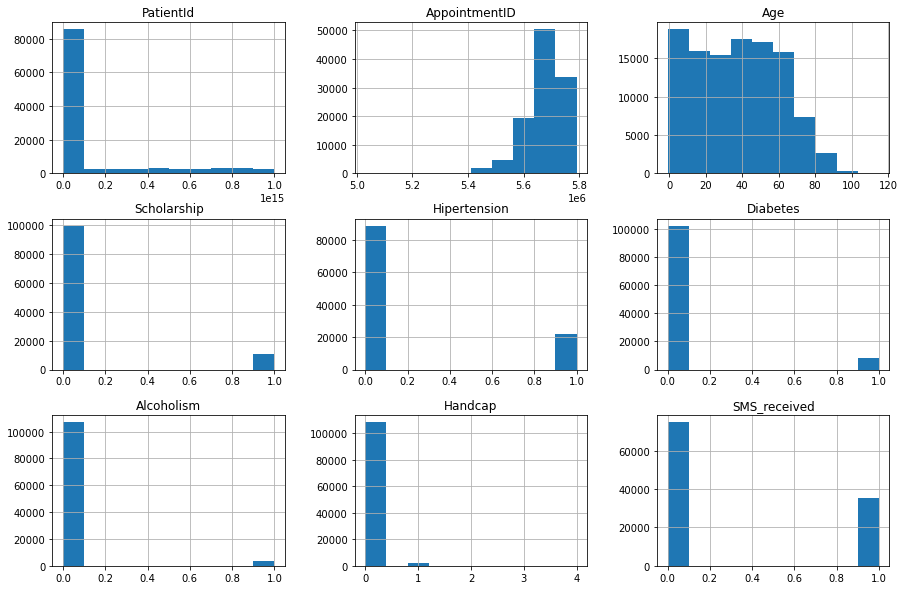

In [169]:

## Plotting all the numeric columns to get an idea of their data distribution

import matplotlib.pyplot as plt
df.hist(layout=(3,3), figsize=(15,10))

plt.show()

In [170]:
## We will not be considering PatientID and Appointment ID in our training columns. Because our data samples are 
## independent and identically distributed so we can remove the sample IDs. It is given that all samples come 
## from or refer to the same source/object and they don't somehow identify the sample class.

df.pop('PatientId')
df.pop('AppointmentID')

print("Columns excluded : PatientId & AppointmentID")

Columns excluded : PatientId & AppointmentID


In [171]:
## By looking at the distributions above, we saw that age variable has some erroneous entries in it, so we will
## settle them first.

## We know that age of a person cannot be less than zero or greater than a certain amount, so we will replace all
##these erroneous entries with NaN, later on we will replace them in our pipeline.

df['Age'] = df['Age'].mask(df['Age'].sub(df['Age'].mean()).div(df['Age'].std()).abs().gt(2))

## Seperating training and test data:

In [172]:
## Using stratified sampling on the No-show variable to ensure test set and training set class proportions 
## are the same


from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.189, random_state=1234)
for train_index, test_index in split.split(df, df["No-show"]):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

In [173]:
## Saving the train and test sets as csv files in the processed_data directory

train_set.to_csv("./processed_data/Trainingdata.csv",index=False)
test_set.to_csv("./processed_data/Testdata.csv",index=False)


In [174]:
## Seperating the independent and dependent variables
X=train_set.loc[:, train_set.columns != 'No-show'] # It will contains all columns except our target column
Y=train_set.loc[:, train_set.columns == 'No-show'] #It will contain target column

## Plot the No-show variable against the other variables in the dataset:

In [175]:
#numerical features
num_cols = X.select_dtypes([int, float]).columns

## Converting target categorical column to numeric column

from sklearn.preprocessing import LabelEncoder
y_converted = LabelEncoder().fit_transform(np.ravel(Y))

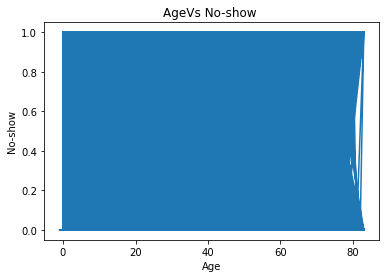

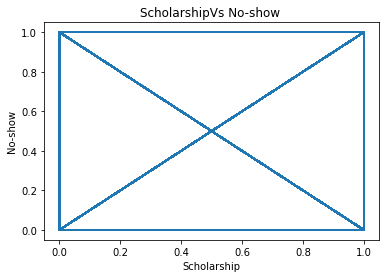

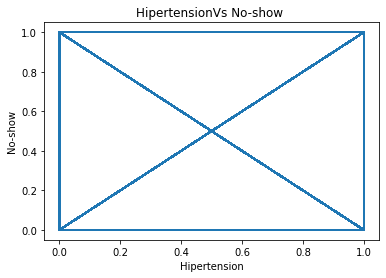

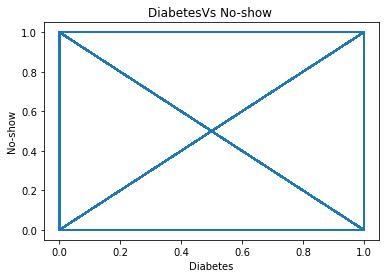

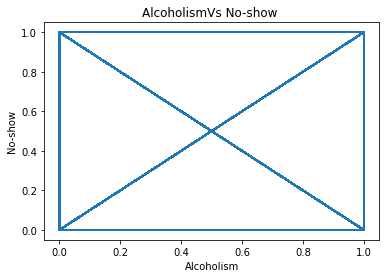

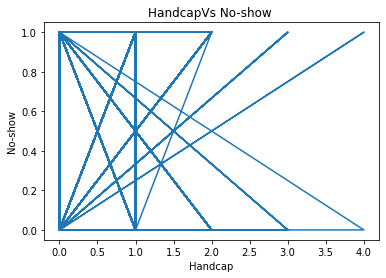

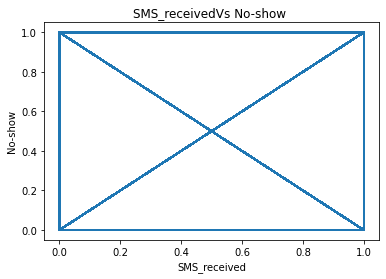

In [176]:
for i in num_cols:
    plt.plot(X[i],y_converted)
    plt.title(i+"Vs No-show ")
    plt.xlabel(i+"")
    plt.ylabel("No-show")
    plt.show()

In [101]:
!pip install sklearn_pipeline_utils
!pip install sklearn_pandas

     |████████████████████████████████| 28.4 MB 667 kB/s eta 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


## Creating a preprocessing pipeline:

In [177]:
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn_pandas import DataFrameMapper

class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, method='mean', to_fill_with='NA'):
        self.method = method
        self.fill = to_fill_with

    def fit(self, X, y=None):
        if self.method in ['mean', 'median']:
            if not all([dtype in [np.number, np.int] for dtype in X.dtypes]):
                raise ValueError('Only mean median and mode method is supported')
        if self.method == 'mean':
            self.fill = X.mean()
        elif self.method == 'median':
            self.fill = X.median()
        elif self.method == 'mode':
            self.fill = X.mode().iloc[0]
        elif self.method == 'fill':
            if type(self.fill) is list and type(X) is pd.DataFrame:
                self.fill = dict([(cname, v) for cname, v in zip(X.columns, self.fill)])
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [181]:
## Making our own pipeline for numerical data

numerical_data_pipeline = DataFrameMapper(
        [(X.select_dtypes([int, float]).columns,
        CustomImputer(method='median'), {'alias': 'numerical_data'}
        )    
        ],input_df=True ,df_out=True)



from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaled_numerical_pipeline = make_pipeline(
    numerical_data_pipeline,
    StandardScaler(),
    MinMaxScaler()
)



In [184]:
numerical_data_pipeline.fit_transform(X)

,numerical_data_0,numerical_data_1,numerical_data_2,numerical_data_3,numerical_data_4,numerical_data_5,numerical_data_6
64781,35.0,0,0,0,0,0,1
33727,52.0,1,0,0,0,0,0
13711,12.0,0,0,0,0,0,0
104875,50.0,0,0,0,0,0,0
51299,17.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
94003,0.0,0,0,0,0,0,0
20314,18.0,0,0,0,0,0,0
83679,71.0,0,0,1,0,0,0
50014,36.0,0,0,0,0,0,0


In [185]:
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder,LabelEncoder
from sklearn_pandas import gen_features

impute_mode_cols = gen_features(
    columns=X.select_dtypes('object').columns,
    classes=[
        {'class':CustomImputer,'method':'mode'},
        {'class':LabelEncoder}
    ]
)

In [192]:
from sklearn.pipeline import FeatureUnion, make_union

categorical_data_pipeline = make_union(
    DataFrameMapper(impute_mode_cols, input_df=True, df_out=True)
)
categorical_data_pipeline.fit_transform(X)

array([[    0,  4137,     2,    38],
       [    0, 45699,    10,    36],
       [    0, 13767,    16,    24],
       ...,
       [    1,  8570,     4,    36],
       [    0, 17503,    13,    39],
       [    0, 35022,     5,    23]])

In [188]:
## Final pipeline for pre-processing our features
features_pipeline = make_union(scaled_numerical_pipeline, 
                      categorical_data_pipeline)

In [191]:
final_X = features_pipeline.fit_transform(X)

## Key Findings:

    The key findings that we have found in the pre processing of our dataset are:
        * Most of our numeric columns have binary values in them i.e 1 or 0. Except for age column.
        
        * Our age variable has some erroreneous entries in it. It has some outliers present in it, which 
          are being checked and removed by looking at their standard deviation from the mean value.
          
        * Missing values in numeric columns are replaced by median and then standardization was 
          applied on them.
        
        * Categorical columns does not have any missing values in them. They are converted to numeric 
          forms by using LabelEncoder.  